In [1]:
import pandas as pd
from skforecast.sarimax import Sarimax
from tqdm import tqdm, trange
from constants import end_date

In [2]:
cols = ['date','ticker','close','rsi','bb_low', 'bb_mid', 'bb_high', 'sharpe_ratio']
df = pd.read_csv("data/price_data.csv", usecols=cols)
df.head()

,date,ticker,close,rsi,bb_low,bb_mid,bb_high,sharpe_ratio
0,2017-01-03,A,43.559391,55.906011,3.757332,3.781197,3.805061,0.548844
1,2017-01-03,AAPL,26.827240,58.487161,3.274114,3.315296,3.356479,0.836831
2,2017-01-03,ABBV,43.078159,53.851836,3.756310,3.777267,3.798224,0.661857
3,2017-01-03,ABT,33.307190,50.624336,3.504776,3.523770,3.542764,0.568612
4,2017-01-03,ACGL,27.224224,59.555791,3.323679,3.345575,3.367472,0.645114


In [3]:
smoke_test = False
if smoke_test:
    df = df[df["ticker"] == "AAPL"]

df.head()

,date,ticker,close,rsi,bb_low,bb_mid,bb_high,sharpe_ratio
0,2017-01-03,A,43.559391,55.906011,3.757332,3.781197,3.805061,0.548844
1,2017-01-03,AAPL,26.827240,58.487161,3.274114,3.315296,3.356479,0.836831
2,2017-01-03,ABBV,43.078159,53.851836,3.756310,3.777267,3.798224,0.661857
3,2017-01-03,ABT,33.307190,50.624336,3.504776,3.523770,3.542764,0.568612
4,2017-01-03,ACGL,27.224224,59.555791,3.323679,3.345575,3.367472,0.645114


In [4]:
train, test = df[df.date <= end_date], df[df.date > end_date]


Training data shape after feature engineering: (1018847, 9)
Feature columns: 5
0:	learn: 289.4240511	total: 764ms	remaining: 19m 4s
200:	learn: 243.5079717	total: 1m 23s	remaining: 8m 57s
400:	learn: 206.8142312	total: 2m 43s	remaining: 7m 28s
600:	learn: 177.7369192	total: 4m 4s	remaining: 6m 5s
800:	learn: 154.9844234	total: 5m 28s	remaining: 4m 46s
1000:	learn: 137.4590687	total: 6m 56s	remaining: 3m 27s
1200:	learn: 124.1839064	total: 8m 19s	remaining: 2m 4s
1400:	learn: 114.2893346	total: 9m 44s	remaining: 41.3s
1499:	learn: 110.4093539	total: 10m 25s	remaining: 0us

Top 10 most important features:
        feature  importance
3       bb_high   27.524793
4  sharpe_ratio   27.218755
1        bb_low   23.219313
2        bb_mid   21.726452
0           rsi    0.310687
5        ticker    0.000000
Test data shape after feature engineering: (25792, 9)
Model Performance Metrics:
RMSE: 231.450086
MAE: 46.664122
R²: 0.761901
Directional Accuracy: 1.0000


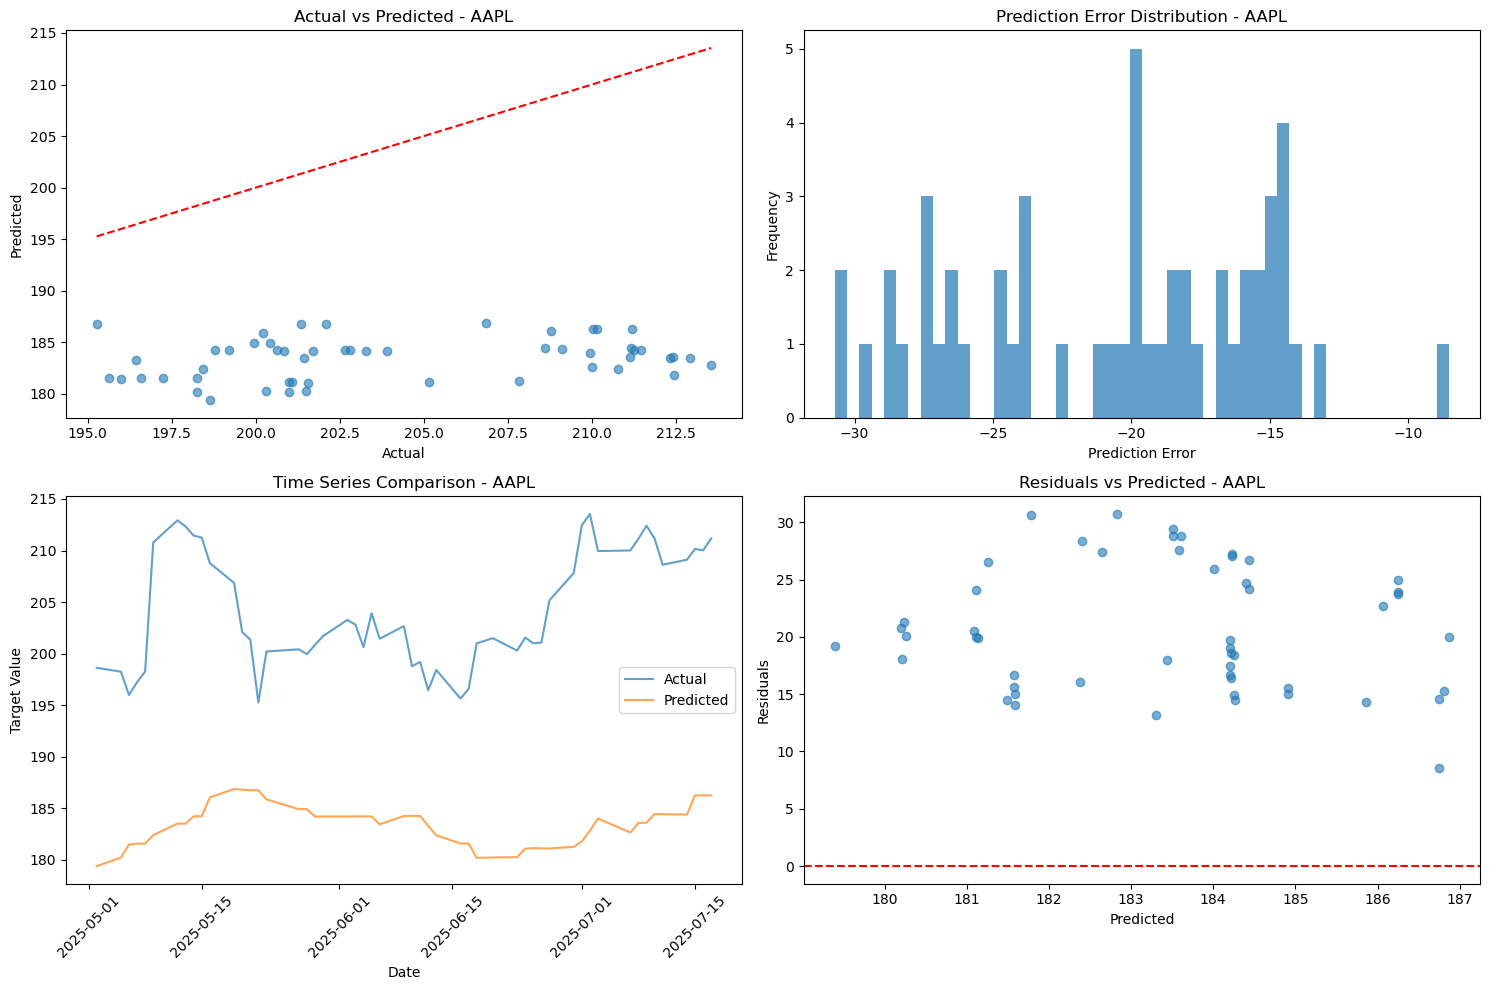

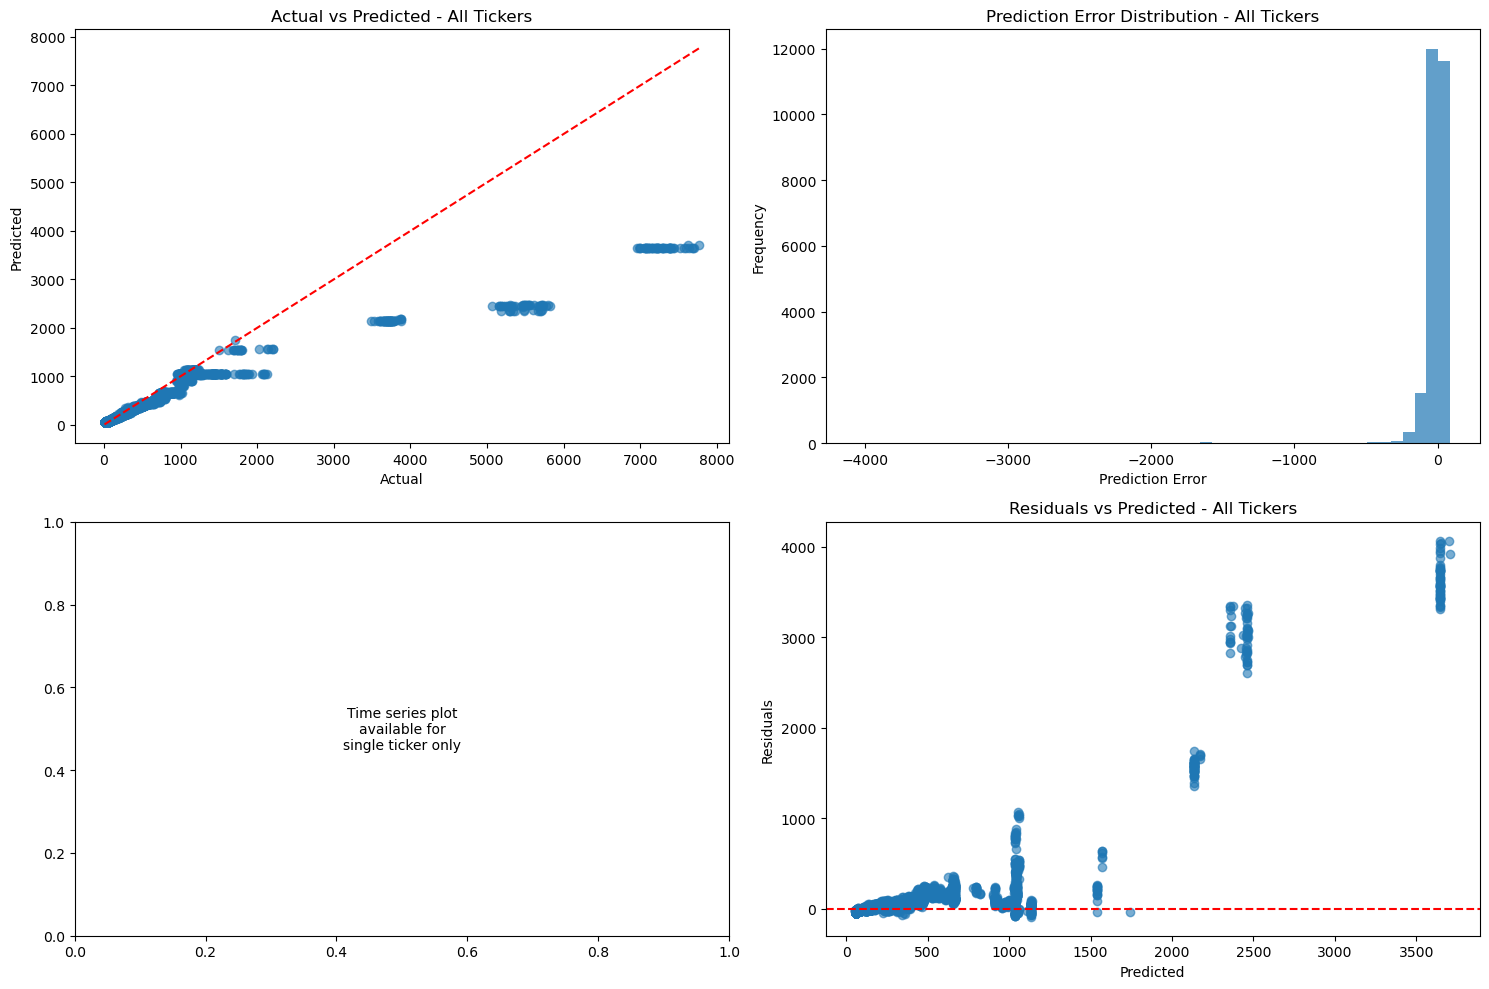

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class StockPredictionModel:
    def __init__(self):
        self.model = None
        self.feature_columns = None
        self.scaler = None
        
    def prepare_features(self, df):
        """
        Prepare features for the model while avoiding data leakage
        """
        # Make a copy to avoid modifying original data
        data = df.copy()
        
        # Convert date to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(data['date']):
            data['date'] = pd.to_datetime(data['date'])
        
        # Sort by ticker and date to ensure proper time series order
        data = data.sort_values(['ticker', 'date']).reset_index(drop=True)
        
        # Create lagged features to avoid data leakage
        # We'll create features based on past values only
        feature_cols = []
        
        # Group by ticker to create lagged features per stock
        for ticker in data['ticker'].unique():
            ticker_mask = data['ticker'] == ticker
            ticker_data = data[ticker_mask].copy()
            
            # Create lagged features (using past values only)
            for lag in [1, 2, 3, 5, 10]:
                ticker_data[f'close_lag_{lag}'] = ticker_data['close'].shift(lag)
                ticker_data[f'rsi_lag_{lag}'] = ticker_data['rsi'].shift(lag)
                
            # Create rolling statistics (using past values only)
            for window in [5, 10, 20]:
                ticker_data[f'close_ma_{window}'] = ticker_data['close'].shift(1).rolling(window=window).mean()
                ticker_data[f'close_std_{window}'] = ticker_data['close'].shift(1).rolling(window=window).std()
                ticker_data[f'rsi_ma_{window}'] = ticker_data['rsi'].shift(1).rolling(window=window).mean()
            
            # Price change features (using lagged prices)
            ticker_data['price_change_1d'] = (ticker_data['close'].shift(1) - ticker_data['close'].shift(2)) / ticker_data['close'].shift(2)
            ticker_data['price_change_5d'] = (ticker_data['close'].shift(1) - ticker_data['close'].shift(6)) / ticker_data['close'].shift(6)
            
            # Bollinger Band position (using lagged values)
            ticker_data['bb_position'] = (ticker_data['close'].shift(1) - ticker_data['bb_low'].shift(1)) / (ticker_data['bb_high'].shift(1) - ticker_data['bb_low'].shift(1))
            
            # RSI momentum
            ticker_data['rsi_momentum'] = ticker_data['rsi'].shift(1) - ticker_data['rsi'].shift(2)
            
            # Update the main dataframe
            data.loc[ticker_mask] = ticker_data
        
        # Define feature columns (excluding date, ticker, and target)
        self.feature_columns = [col for col in data.columns if col not in ['date', 'ticker', 'close']]
        
        # Add categorical features
        categorical_features = ['ticker']
        
        return data, categorical_features
    
    def create_target(self, df, target_type='next_day_return'):
        """
        Create target variable for prediction
        """
        data = df.copy()
        data = data.sort_values(['ticker', 'date']).reset_index(drop=True)
        
        if target_type == 'next_day_return':
            # Predict next day return
            for ticker in data['ticker'].unique():
                ticker_mask = data['ticker'] == ticker
                ticker_data = data[ticker_mask].copy()
                ticker_data['target'] = (ticker_data['close'].shift(-1) - ticker_data['close']) / ticker_data['close']
                data.loc[ticker_mask, 'target'] = ticker_data['target']
        
        elif target_type == 'next_day_price':
            # Predict next day price
            for ticker in data['ticker'].unique():
                ticker_mask = data['ticker'] == ticker
                ticker_data = data[ticker_mask].copy()
                ticker_data['target'] = ticker_data['close'].shift(-1)
                data.loc[ticker_mask, 'target'] = ticker_data['target']
        
        return data
    
    def train_model(self, train_df, target_type='next_day_return', model_params=None):
        """
        Train the CatBoost model
        """
        # Prepare features and target
        train_data, categorical_features = self.prepare_features(train_df)
        train_data = self.create_target(train_data, target_type)
        
        # Remove rows with NaN values (due to lagged features and target creation)
        train_data = train_data.dropna()
        
        print(f"Training data shape after feature engineering: {train_data.shape}")
        print(f"Feature columns: {len(self.feature_columns)}")
        
        # Prepare training data
        X_train = train_data[self.feature_columns + ['ticker']]
        y_train = train_data['target']
        
        # Default CatBoost parameters optimized for financial data
        if model_params is None:
            model_params = {
                'iterations': 1000,
                'learning_rate': 0.1,
                'depth': 6,
                'l2_leaf_reg': 3,
                'random_seed': 42,
                'verbose': 100,
                'early_stopping_rounds': 50,
                'use_best_model': True,
                'eval_metric': 'RMSE'
            }
        
        # Create CatBoost pools
        train_pool = Pool(
            data=X_train,
            label=y_train,
            cat_features=categorical_features
        )
        
        # Initialize and train model
        self.model = CatBoostRegressor(**model_params)
        self.model.fit(train_pool)
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns + categorical_features,
            'importance': self.model.get_feature_importance()
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 most important features:")
        print(feature_importance.head(10))
        
        return self.model, feature_importance
    
    def predict(self, test_df, target_type='next_day_return'):
        """
        Make predictions on test data
        """
        if self.model is None:
            raise ValueError("Model not trained yet. Call train_model() first.")
        
        # Prepare features (using the same feature engineering as training)
        test_data, _ = self.prepare_features(test_df)
        test_data = self.create_target(test_data, target_type)  # We need this to align data structure
        
        # Remove rows with NaN values
        test_data_clean = test_data.dropna()
        
        print(f"Test data shape after feature engineering: {test_data_clean.shape}")
        
        # Prepare test features
        X_test = test_data_clean[self.feature_columns + ['ticker']]
        
        # Make predictions
        predictions = self.model.predict(X_test)
        
        # Create results dataframe
        results = test_data_clean[['date', 'ticker', 'close', 'target']].copy()
        results['predicted'] = predictions
        results['actual_target'] = results['target']
        
        return results
    
    def evaluate_model(self, results_df):
        """
        Evaluate model performance
        """
        # Remove any remaining NaN values
        eval_data = results_df.dropna()
        
        # Calculate metrics
        mse = mean_squared_error(eval_data['actual_target'], eval_data['predicted'])
        mae = mean_absolute_error(eval_data['actual_target'], eval_data['predicted'])
        rmse = np.sqrt(mse)
        r2 = r2_score(eval_data['actual_target'], eval_data['predicted'])
        
        print("Model Performance Metrics:")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R²: {r2:.6f}")
        
        # Directional accuracy (for return prediction)
        if 'actual_target' in eval_data.columns:
            correct_direction = ((eval_data['actual_target'] > 0) == (eval_data['predicted'] > 0)).mean()
            print(f"Directional Accuracy: {correct_direction:.4f}")
        
        return {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': correct_direction if 'actual_target' in eval_data.columns else None
        }
    
    def plot_results(self, results_df, ticker=None):
        """
        Plot prediction results
        """
        plot_data = results_df.copy()
        
        if ticker:
            plot_data = plot_data[plot_data['ticker'] == ticker]
            title_suffix = f" - {ticker}"
        else:
            title_suffix = " - All Tickers"
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Actual vs Predicted scatter plot
        axes[0, 0].scatter(plot_data['actual_target'], plot_data['predicted'], alpha=0.6)
        axes[0, 0].plot([plot_data['actual_target'].min(), plot_data['actual_target'].max()], 
                       [plot_data['actual_target'].min(), plot_data['actual_target'].max()], 'r--')
        axes[0, 0].set_xlabel('Actual')
        axes[0, 0].set_ylabel('Predicted')
        axes[0, 0].set_title(f'Actual vs Predicted{title_suffix}')
        
        # Prediction errors
        errors = plot_data['predicted'] - plot_data['actual_target']
        axes[0, 1].hist(errors, bins=50, alpha=0.7)
        axes[0, 1].set_xlabel('Prediction Error')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title(f'Prediction Error Distribution{title_suffix}')
        
        # Time series of predictions (if ticker specified)
        if ticker and len(plot_data) > 1:
            plot_data_sorted = plot_data.sort_values('date')
            axes[1, 0].plot(plot_data_sorted['date'], plot_data_sorted['actual_target'], label='Actual', alpha=0.7)
            axes[1, 0].plot(plot_data_sorted['date'], plot_data_sorted['predicted'], label='Predicted', alpha=0.7)
            axes[1, 0].set_xlabel('Date')
            axes[1, 0].set_ylabel('Target Value')
            axes[1, 0].set_title(f'Time Series Comparison{title_suffix}')
            axes[1, 0].legend()
            axes[1, 0].tick_params(axis='x', rotation=45)
        else:
            axes[1, 0].text(0.5, 0.5, 'Time series plot\navailable for\nsingle ticker only', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
        
        # Residuals vs Predicted
        residuals = plot_data['actual_target'] - plot_data['predicted']
        axes[1, 1].scatter(plot_data['predicted'], residuals, alpha=0.6)
        axes[1, 1].axhline(y=0, color='r', linestyle='--')
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].set_title(f'Residuals vs Predicted{title_suffix}')
        
        plt.tight_layout()
        plt.show()

# Example usage:

# Initialize the model
stock_model = StockPredictionModel()

# Train the model (assuming you have train_df already split by date)
model, feature_importance = stock_model.train_model(
    train, 
    target_type='next_day_price',  # or 'next_day_price'
    model_params={
        'iterations': 1500,
        'learning_rate': 0.001,
        'depth': 8,
        'l2_leaf_reg': 5,
        'random_seed': 42,
        'verbose': 200
    }
)

# Make predictions on test data
predictions = stock_model.predict(test, target_type='next_day_price')

# Evaluate the model
metrics = stock_model.evaluate_model(predictions)

# Plot results for a specific ticker or all tickers
stock_model.plot_results(predictions)  # For all tickers


# Load the model later
# loaded_model = CatBoostRegressor()
# loaded_model.load_model('stock_prediction_model.cbm')

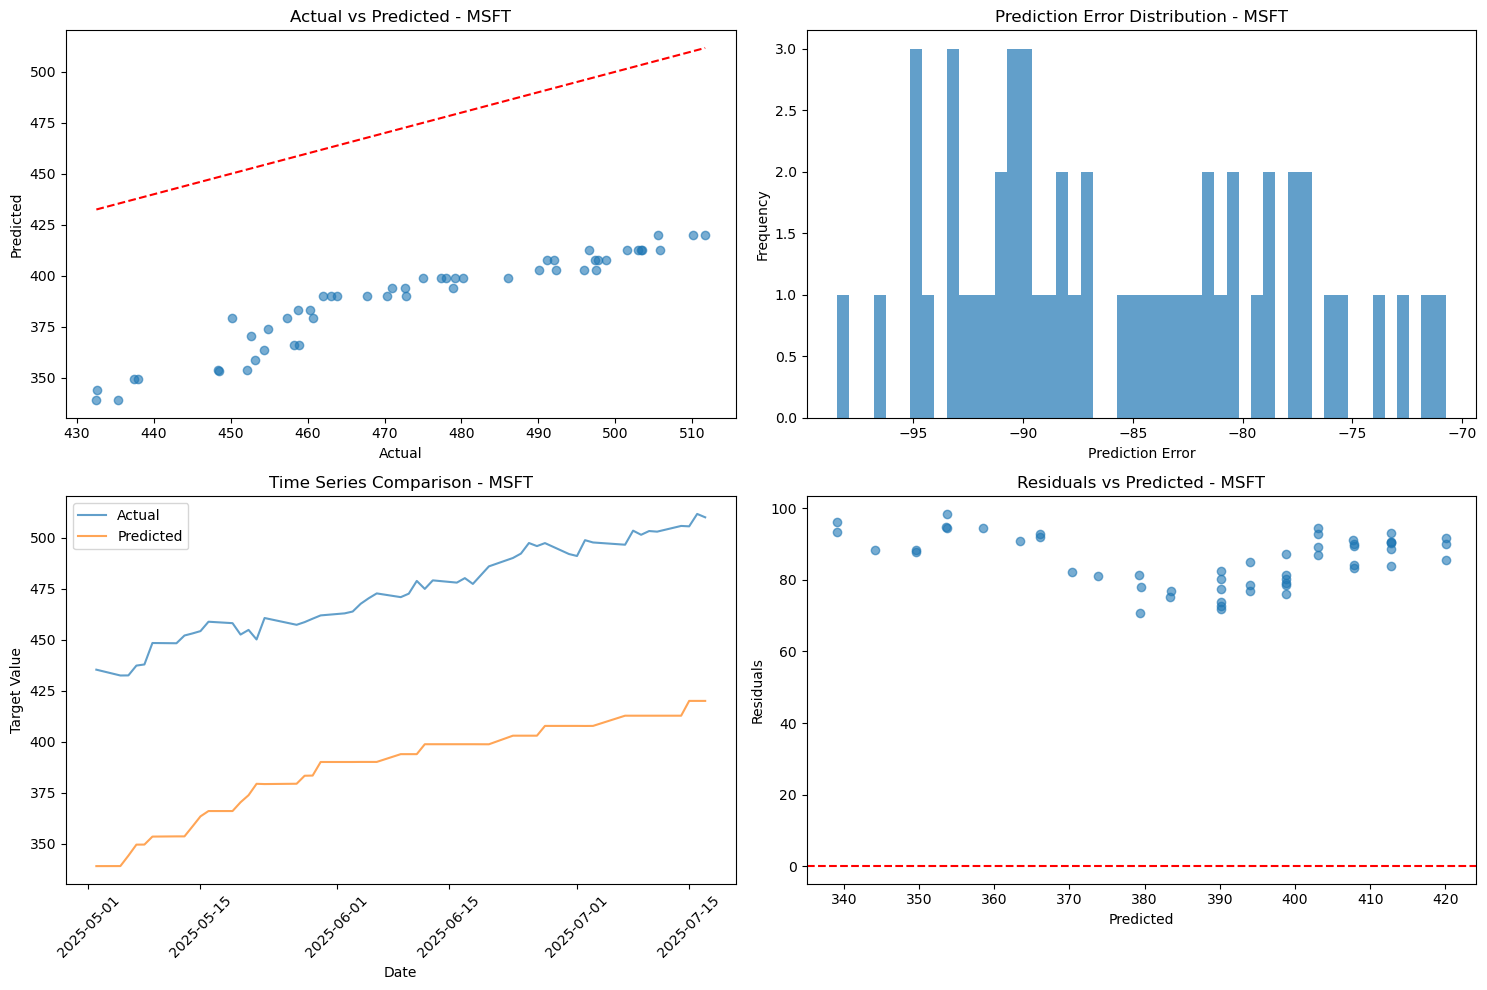

In [8]:
stock_model.plot_results(predictions, ticker='MSFT')  # For specific ticker
